# Generative Models
***

**MIPT, Autumn 2022, MSc course**


## Assignment 1

***


*Authored by Arip Asadulaev & Manh Lab*

*Adapted by Alexander Panfilov*

***


The assignment is split into two parts: at first, you will implement classical GAN for the MNIST dataset, and after, you will enhance your results with DCGAN and the CIFAR dataset. 

Good luck!

## 1. GAN
*Source: <a href="https://arxiv.org/pdf/1406.2661.pdf" target="_blank">Goodfellow, Ian J., et al. "Generative Adversarial Networks." arXiv preprint arXiv:1406.2661 (2014)</a>.*

In 2014, Ian Goodfellow and his colleagues at the University of Montreal published a stunning paper introducing the world to GANs, or generative adversarial networks. The models play two distinct (literally, adversarial) roles. Given some real data set $\mathcal{X}$, $G$ is the generator, trying to create fake data that looks just like the genuine data, while $D$ is the discriminator, getting data from either the real set or $G$ and labeling the difference.

Goodfellow’s metaphor (and a fine one it is) was that $G$ was like a team of forgers trying to match real paintings with their output, while $D$ was the team of detectives trying to tell the difference. (Except in this case, the forgers $G$ never get to see the original data — only the judgments of $D$. They’re like blind forgers.)

<img src="https://production-media.paperswithcode.com/methods/gan.jpeg" style="display=block; margin:auto"/>
<p style="text-align: center">
    <b>Picture taken from the <a href="https://paperswithcode.com/method/gan" target="_blank">paperswithcode</a> website. There you can find a whole bunch of papers on GANs with implementation.</b>
</p>

In this part, we are going to implement classical GAN. You can find a rough plan on how to do it below; however, it is not mandatory to stick with it precisely but one might expect some questions related to the listed steps. Feel free to adapt provided code!

- Define the parameters
- Load the data (with transforms and normalization)
- Denormalize for visual inspection of samples
- Define the Discriminator network, the Generator network
- Study the activation function: Leaky ReLU
- Explain the output activation function: Tanh, Sigmoid
- Look at some sample outputs
- Define losses, optimizers and helper functions for training
     - For Discriminator
     - For Generator
- Train the model
- Save intermediate generated images to file
- Look at some outputs
- Save the models

### Imports

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms
from torchvision.datasets import CIFAR10, MNIST
from torchvision.transforms import Compose, Normalize, ToTensor
from torchvision.utils import save_image
from torch.autograd import Variable

%matplotlib inline
plt.style.use("ggplot")

### Define parameters & data loading 

In [2]:
hidden_size = 256
batch_size = 100
LR = 0.0002
num_epochs = 300
sample_dir = "./images"
latent_size = 64  # input random input vector latent
image_size = 784  # 28*28 flatten
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)
## Define the dataset
mnist_dataset = MNIST(
    root="data",
    train=True,
    download=True,
    transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]),
)

cuda:0


/home/kontsevaya/sberocrs/sber-ocr-2/.sberocr-env2/lib/python3.6/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Label:  5


(array([[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 1.]]),
 array([-1.        , -0.86771244, -0.7354248 , -0.60313725, -0.47084966,
        -0.3385621 , -0.20627451, -0.07398693,  0.05830066,  0.19058824,
         0.32287583,  0.4551634 ,  0.587451  ,  0.71973854,  0.85202616,
         0.9843137 ], dtype=float32),
 <a list of 100 BarContainer objects>)

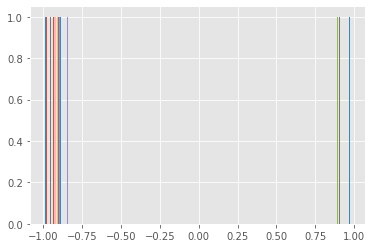

In [3]:
img, label = mnist_dataset[0]
print("Label: ", label)
plt.hist(img[:, 5:15, 5:15].flatten(), bins=15)

In [4]:
# denormalization image from range (-1)-1 to range 0-1 to display it
def denorm(x):
    return torch.sigmoid(x)
denorm(img) 

tensor([[[0.2689, 0.2689, 0.2689, 0.2689, 0.2689, 0.2689, 0.2689, 0.2689,
          0.2689, 0.2689, 0.2689, 0.2689, 0.2689, 0.2689, 0.2689, 0.2689,
          0.2689, 0.2689, 0.2689, 0.2689, 0.2689, 0.2689, 0.2689, 0.2689,
          0.2689, 0.2689, 0.2689, 0.2689],
         [0.2689, 0.2689, 0.2689, 0.2689, 0.2689, 0.2689, 0.2689, 0.2689,
          0.2689, 0.2689, 0.2689, 0.2689, 0.2689, 0.2689, 0.2689, 0.2689,
          0.2689, 0.2689, 0.2689, 0.2689, 0.2689, 0.2689, 0.2689, 0.2689,
          0.2689, 0.2689, 0.2689, 0.2689],
         [0.2689, 0.2689, 0.2689, 0.2689, 0.2689, 0.2689, 0.2689, 0.2689,
          0.2689, 0.2689, 0.2689, 0.2689, 0.2689, 0.2689, 0.2689, 0.2689,
          0.2689, 0.2689, 0.2689, 0.2689, 0.2689, 0.2689, 0.2689, 0.2689,
          0.2689, 0.2689, 0.2689, 0.2689],
         [0.2689, 0.2689, 0.2689, 0.2689, 0.2689, 0.2689, 0.2689, 0.2689,
          0.2689, 0.2689, 0.2689, 0.2689, 0.2689, 0.2689, 0.2689, 0.2689,
          0.2689, 0.2689, 0.2689, 0.2689, 0.2689, 0.2689,

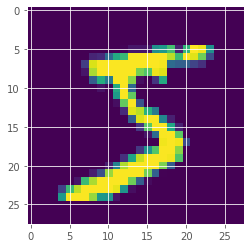

In [6]:
# show image sample with matplotlib
import matplotlib.pyplot as plt

denorm_img = denorm(img)
plt.imshow(torch.permute(denorm_img, (1, 2, 0))[:,:,0])

In [7]:
# define the dataloader
data_loader = torch.utils.data.DataLoader(mnist_dataset,
                                          batch_size=batch_size,
                                          shuffle=True,
)

### GAN implementation

GAN consists of two deep networks, a generator ($G$) and a discriminator ($D$). The generator creates images before learning it. Since the discriminator is a binary classification model, we can use the binary cross-entropy loss function to quantify how well it can distinguish between real and generated images.

In [5]:
class Generator(nn.Module):
    def __init__(self, latent_size, image_size, hidden_size):
        super(Generator, self).__init__()
        ## set a linear layer with input size is latent_size and output size is hidden_size
        self.linear1 = nn.Linear(latent_size, hidden_size)

        # set a linear layer with input size is hidden_size and output size is hidden_size
        self.linear2 = nn.Linear(hidden_size, hidden_size)

        # set a linear layer with input size is hidden_size and output size is image_size
        self.linear3 = nn.Linear(hidden_size, image_size)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, x):
        # forward x -> linear1 -> relu -> linear2 -> relu -> linear3 -> tanh
        l1 = self.relu(self.linear1(x))
        l2 = self.relu(self.linear2(l1))
        l3 = self.tanh(self.linear3(l2))
        return l3


class Discriminator(nn.Module):
    def __init__(self, image_size, hidden_size):
        super(Discriminator, self).__init__()
        ## set a linear layer with input size is image_size and output size is hidden_size
        self.linear1 = nn.Linear(image_size, hidden_size)

        # set a linear layer with input size is hidden_size and output size is hidden_size
        self.linear2 = nn.Linear(hidden_size, hidden_size)

        # set a linear layer with input size is hidden_size and output size is 1
        self.linear3 = nn.Linear(hidden_size, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # forward x -> linear1 -> relu -> linear2 -> relu -> linear3 -> sigmoid
        l1 = self.relu(self.linear1(x))
        l2 = self.relu(self.linear2(l1))
        l3 = self.sigmoid(self.linear3(l2))
        return l3

### Create the Generator and Discriminator

In [15]:
# create new Generator model
G = Generator(latent_size, image_size, hidden_size).to(device)

# create new Discriminator model
D = Discriminator(image_size, hidden_size).to(device)

In [16]:
# show the output of model
y = G(torch.randn(2, latent_size).to(device))
y

tensor([[-0.0162, -0.0302, -0.0373,  ..., -0.1324, -0.1233, -0.0702],
        [-0.0175, -0.0033, -0.0162,  ..., -0.0944, -0.0537,  0.0453]],
       device='cuda:0', grad_fn=<TanhBackward>)

In [17]:
# define the criterion is nn.BCELoss()
criterion = nn.BCELoss()
## Define the optimizer for generator and discrimator
lr = 2e-4
beta1 = 0.5
G_optimizer = torch.optim.Adam(G.parameters(), lr=lr, betas=(beta1, 0.999))
D_optimizer = torch.optim.Adam(D.parameters(), lr=lr, betas=(beta1, 0.999))

Discriminator Training

In [6]:
def train_discriminator(D_model, G_model, images, z_shape=(batch_size, latent_size)):
    # Create the labels which are later used as input for the BCE loss
    real_labels = Variable(torch.ones(batch_size, 1).to(device))
    fake_labels = Variable(torch.zeros(batch_size, 1).to(device))

    outputs = D_model(images).squeeze().unsqueeze(1)
    # Loss for real images

    real_loss = criterion(outputs, real_labels)
    real_score = outputs 

    # Loss for fake images
    z = Variable(torch.randn(z_shape).to(device))
    fake_images = G_model(z)
    outputs = D_model(fake_images).squeeze().unsqueeze(1)
    fake_score = outputs
    fake_loss = criterion(outputs, fake_labels)

    # Sum losses
    loss = real_loss + fake_loss
    
    # Reset gradients
    G_optimizer.zero_grad()
    D_optimizer.zero_grad()
    
    loss.backward()
    
    D_optimizer.step()
    
    return loss, real_score, fake_score

Generator Training

In [7]:
def train_generator(G_model, D_model, z_shape=(batch_size, latent_size)):
    # Generate fake images and calculate loss
    # z = torch.randn(batch_size, latent_size).to(device)
    z = Variable(torch.Tensor(np.random.normal(0, 1, z_shape)).to(device))
    fake_images = G_model(z)
    labels = torch.ones(batch_size, 1).to(device)
    
    # calculate the generator loss
    loss = criterion(D_model(fake_images).squeeze().unsqueeze(1), labels)#.squeeze().unsqueeze(1)
    
    G_optimizer.zero_grad()
    D_optimizer.zero_grad()
    
    # Backprop and optimize
    loss.backward()
    
    G_optimizer.step()
    return loss, fake_images

### Start the training proccess

In [8]:
# function to save the sample output of generator
def save_fake_images_mnist(G_model, index):
    # sample_vectors = torch.randn(batch_size, latent_size).to(device)
    sample_vectors = torch.Tensor(np.random.normal(0, 1, (batch_size, latent_size))).to(
        device
    )
    fake_images = G_model(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = "fake_images-{0:0=4d}.png".format(index)
    print("Saving", fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

In [21]:
%%time
total_step = len(data_loader)
print(total_step)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []
G.to(device)
D.to(device)
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = Variable(images.reshape(batch_size, -1).to(device))

        # Train the discriminator
        #if (i + 1) % 20 == 0:
        d_loss, real_score, fake_score = train_discriminator(D, G, images)
        # Train the generator
        g_loss, fake_images = train_generator(G, D)
        # Inspect the losses
        if (i + 1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print(
                "Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}".format(
                    epoch,
                    num_epochs,
                    i + 1,
                    total_step,
                    d_loss.item(),
                    g_loss.item(),
                    real_score.mean().item(),
                    fake_score.mean().item(),
                )
            )
 
    # Sample and save images
    save_fake_images_mnist(G, epoch + 1)

600
Epoch [0/300], Step [200/600], d_loss: 0.8479, g_loss: 1.1570, D(x): 0.69, D(G(z)): 0.37
Epoch [0/300], Step [400/600], d_loss: 0.4456, g_loss: 1.7715, D(x): 0.84, D(G(z)): 0.22
Epoch [0/300], Step [600/600], d_loss: 0.4619, g_loss: 2.4097, D(x): 0.88, D(G(z)): 0.26
Saving fake_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.6574, g_loss: 1.9332, D(x): 0.74, D(G(z)): 0.21
Epoch [1/300], Step [400/600], d_loss: 0.1902, g_loss: 2.6214, D(x): 0.90, D(G(z)): 0.06
Epoch [1/300], Step [600/600], d_loss: 0.4064, g_loss: 1.9386, D(x): 0.78, D(G(z)): 0.06
Saving fake_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 0.4136, g_loss: 2.3889, D(x): 0.78, D(G(z)): 0.06
Epoch [2/300], Step [400/600], d_loss: 0.2755, g_loss: 2.7456, D(x): 0.92, D(G(z)): 0.15
Epoch [2/300], Step [600/600], d_loss: 0.2636, g_loss: 3.0754, D(x): 0.89, D(G(z)): 0.05
Saving fake_images-0003.png
Epoch [3/300], Step [200/600], d_loss: 0.2428, g_loss: 3.5301, D(x): 0.91, D(G(z)): 0.10
Epoch [3/300], Step [4

Epoch [27/300], Step [600/600], d_loss: 0.4719, g_loss: 2.3640, D(x): 0.86, D(G(z)): 0.19
Saving fake_images-0028.png
Epoch [28/300], Step [200/600], d_loss: 0.5776, g_loss: 2.2285, D(x): 0.84, D(G(z)): 0.22
Epoch [28/300], Step [400/600], d_loss: 0.6538, g_loss: 1.9762, D(x): 0.77, D(G(z)): 0.13
Epoch [28/300], Step [600/600], d_loss: 0.5206, g_loss: 1.9295, D(x): 0.82, D(G(z)): 0.15
Saving fake_images-0029.png
Epoch [29/300], Step [200/600], d_loss: 0.5578, g_loss: 2.8278, D(x): 0.85, D(G(z)): 0.23
Epoch [29/300], Step [400/600], d_loss: 0.5755, g_loss: 2.2316, D(x): 0.82, D(G(z)): 0.19
Epoch [29/300], Step [600/600], d_loss: 0.6010, g_loss: 1.8729, D(x): 0.79, D(G(z)): 0.15
Saving fake_images-0030.png
Epoch [30/300], Step [200/600], d_loss: 0.6766, g_loss: 2.0819, D(x): 0.82, D(G(z)): 0.25
Epoch [30/300], Step [400/600], d_loss: 0.5116, g_loss: 1.9514, D(x): 0.87, D(G(z)): 0.19
Epoch [30/300], Step [600/600], d_loss: 0.5441, g_loss: 2.2456, D(x): 0.85, D(G(z)): 0.17
Saving fake_imag

Epoch [55/300], Step [400/600], d_loss: 0.4641, g_loss: 1.9971, D(x): 0.88, D(G(z)): 0.21
Epoch [55/300], Step [600/600], d_loss: 0.7182, g_loss: 1.6850, D(x): 0.76, D(G(z)): 0.19
Saving fake_images-0056.png
Epoch [56/300], Step [200/600], d_loss: 0.6004, g_loss: 1.7643, D(x): 0.81, D(G(z)): 0.19
Epoch [56/300], Step [400/600], d_loss: 0.5876, g_loss: 1.8283, D(x): 0.81, D(G(z)): 0.16
Epoch [56/300], Step [600/600], d_loss: 0.5872, g_loss: 1.9111, D(x): 0.79, D(G(z)): 0.15
Saving fake_images-0057.png
Epoch [57/300], Step [200/600], d_loss: 0.4832, g_loss: 2.0799, D(x): 0.85, D(G(z)): 0.17
Epoch [57/300], Step [400/600], d_loss: 0.5387, g_loss: 2.1652, D(x): 0.84, D(G(z)): 0.18
Epoch [57/300], Step [600/600], d_loss: 0.5480, g_loss: 1.8638, D(x): 0.82, D(G(z)): 0.17
Saving fake_images-0058.png
Epoch [58/300], Step [200/600], d_loss: 0.5165, g_loss: 1.7963, D(x): 0.82, D(G(z)): 0.17
Epoch [58/300], Step [400/600], d_loss: 0.6037, g_loss: 2.0909, D(x): 0.83, D(G(z)): 0.22
Epoch [58/300], 

Epoch [83/300], Step [200/600], d_loss: 0.5367, g_loss: 1.9904, D(x): 0.85, D(G(z)): 0.21
Epoch [83/300], Step [400/600], d_loss: 0.5209, g_loss: 1.6087, D(x): 0.84, D(G(z)): 0.19
Epoch [83/300], Step [600/600], d_loss: 0.6130, g_loss: 2.0857, D(x): 0.82, D(G(z)): 0.19
Saving fake_images-0084.png
Epoch [84/300], Step [200/600], d_loss: 0.4681, g_loss: 1.8933, D(x): 0.85, D(G(z)): 0.17
Epoch [84/300], Step [400/600], d_loss: 0.6263, g_loss: 1.9259, D(x): 0.79, D(G(z)): 0.17
Epoch [84/300], Step [600/600], d_loss: 0.7450, g_loss: 2.0436, D(x): 0.80, D(G(z)): 0.23
Saving fake_images-0085.png
Epoch [85/300], Step [200/600], d_loss: 0.6178, g_loss: 1.8060, D(x): 0.85, D(G(z)): 0.24
Epoch [85/300], Step [400/600], d_loss: 0.7218, g_loss: 1.6979, D(x): 0.75, D(G(z)): 0.15
Epoch [85/300], Step [600/600], d_loss: 0.6672, g_loss: 1.8577, D(x): 0.79, D(G(z)): 0.18
Saving fake_images-0086.png
Epoch [86/300], Step [200/600], d_loss: 0.6517, g_loss: 1.6457, D(x): 0.80, D(G(z)): 0.22
Epoch [86/300], 

Epoch [110/300], Step [600/600], d_loss: 0.5876, g_loss: 1.6998, D(x): 0.79, D(G(z)): 0.15
Saving fake_images-0111.png
Epoch [111/300], Step [200/600], d_loss: 0.6108, g_loss: 1.9788, D(x): 0.80, D(G(z)): 0.20
Epoch [111/300], Step [400/600], d_loss: 0.4810, g_loss: 2.0172, D(x): 0.87, D(G(z)): 0.20
Epoch [111/300], Step [600/600], d_loss: 0.6235, g_loss: 1.8437, D(x): 0.80, D(G(z)): 0.19
Saving fake_images-0112.png
Epoch [112/300], Step [200/600], d_loss: 0.4898, g_loss: 2.2684, D(x): 0.83, D(G(z)): 0.13
Epoch [112/300], Step [400/600], d_loss: 0.5279, g_loss: 2.0132, D(x): 0.84, D(G(z)): 0.19
Epoch [112/300], Step [600/600], d_loss: 0.5621, g_loss: 1.8735, D(x): 0.82, D(G(z)): 0.18
Saving fake_images-0113.png
Epoch [113/300], Step [200/600], d_loss: 0.7278, g_loss: 1.4887, D(x): 0.72, D(G(z)): 0.16
Epoch [113/300], Step [400/600], d_loss: 0.6418, g_loss: 1.6022, D(x): 0.77, D(G(z)): 0.18
Epoch [113/300], Step [600/600], d_loss: 0.6171, g_loss: 1.9886, D(x): 0.77, D(G(z)): 0.15
Saving

Epoch [138/300], Step [200/600], d_loss: 0.6401, g_loss: 1.9150, D(x): 0.77, D(G(z)): 0.15
Epoch [138/300], Step [400/600], d_loss: 0.4671, g_loss: 1.8979, D(x): 0.87, D(G(z)): 0.18
Epoch [138/300], Step [600/600], d_loss: 0.6198, g_loss: 1.9762, D(x): 0.78, D(G(z)): 0.15
Saving fake_images-0139.png
Epoch [139/300], Step [200/600], d_loss: 0.6553, g_loss: 1.9677, D(x): 0.77, D(G(z)): 0.18
Epoch [139/300], Step [400/600], d_loss: 0.5734, g_loss: 2.3026, D(x): 0.80, D(G(z)): 0.15
Epoch [139/300], Step [600/600], d_loss: 0.6361, g_loss: 1.9827, D(x): 0.78, D(G(z)): 0.15
Saving fake_images-0140.png
Epoch [140/300], Step [200/600], d_loss: 0.4456, g_loss: 2.1665, D(x): 0.85, D(G(z)): 0.14
Epoch [140/300], Step [400/600], d_loss: 0.7029, g_loss: 2.2204, D(x): 0.80, D(G(z)): 0.23
Epoch [140/300], Step [600/600], d_loss: 0.6221, g_loss: 2.0011, D(x): 0.82, D(G(z)): 0.21
Saving fake_images-0141.png
Epoch [141/300], Step [200/600], d_loss: 0.5002, g_loss: 1.7488, D(x): 0.84, D(G(z)): 0.18
Epoch 

Epoch [165/300], Step [400/600], d_loss: 0.6285, g_loss: 1.8465, D(x): 0.80, D(G(z)): 0.19
Epoch [165/300], Step [600/600], d_loss: 0.5714, g_loss: 1.9929, D(x): 0.83, D(G(z)): 0.19
Saving fake_images-0166.png
Epoch [166/300], Step [200/600], d_loss: 0.5596, g_loss: 2.1338, D(x): 0.82, D(G(z)): 0.14
Epoch [166/300], Step [400/600], d_loss: 0.5189, g_loss: 2.1932, D(x): 0.83, D(G(z)): 0.15
Epoch [166/300], Step [600/600], d_loss: 0.4550, g_loss: 2.0774, D(x): 0.85, D(G(z)): 0.15
Saving fake_images-0167.png
Epoch [167/300], Step [200/600], d_loss: 0.4154, g_loss: 2.1959, D(x): 0.86, D(G(z)): 0.13
Epoch [167/300], Step [400/600], d_loss: 0.4945, g_loss: 2.0219, D(x): 0.85, D(G(z)): 0.16
Epoch [167/300], Step [600/600], d_loss: 0.5296, g_loss: 2.0052, D(x): 0.83, D(G(z)): 0.16
Saving fake_images-0168.png
Epoch [168/300], Step [200/600], d_loss: 0.4918, g_loss: 2.1610, D(x): 0.85, D(G(z)): 0.15
Epoch [168/300], Step [400/600], d_loss: 0.5586, g_loss: 1.9399, D(x): 0.81, D(G(z)): 0.14
Epoch 

Epoch [192/300], Step [600/600], d_loss: 0.5343, g_loss: 2.1032, D(x): 0.81, D(G(z)): 0.15
Saving fake_images-0193.png
Epoch [193/300], Step [200/600], d_loss: 0.5679, g_loss: 2.0735, D(x): 0.84, D(G(z)): 0.20
Epoch [193/300], Step [400/600], d_loss: 0.5519, g_loss: 2.2163, D(x): 0.81, D(G(z)): 0.13
Epoch [193/300], Step [600/600], d_loss: 0.4639, g_loss: 2.1615, D(x): 0.86, D(G(z)): 0.16
Saving fake_images-0194.png
Epoch [194/300], Step [200/600], d_loss: 0.5886, g_loss: 1.8643, D(x): 0.79, D(G(z)): 0.17
Epoch [194/300], Step [400/600], d_loss: 0.5413, g_loss: 2.1832, D(x): 0.86, D(G(z)): 0.19
Epoch [194/300], Step [600/600], d_loss: 0.6332, g_loss: 2.0086, D(x): 0.80, D(G(z)): 0.16
Saving fake_images-0195.png
Epoch [195/300], Step [200/600], d_loss: 0.4288, g_loss: 2.4146, D(x): 0.86, D(G(z)): 0.14
Epoch [195/300], Step [400/600], d_loss: 0.3922, g_loss: 1.9467, D(x): 0.87, D(G(z)): 0.14
Epoch [195/300], Step [600/600], d_loss: 0.5718, g_loss: 1.8495, D(x): 0.83, D(G(z)): 0.18
Saving

Epoch [220/300], Step [200/600], d_loss: 0.4341, g_loss: 2.5620, D(x): 0.88, D(G(z)): 0.15
Epoch [220/300], Step [400/600], d_loss: 0.5451, g_loss: 2.1314, D(x): 0.85, D(G(z)): 0.17
Epoch [220/300], Step [600/600], d_loss: 0.5491, g_loss: 1.9186, D(x): 0.82, D(G(z)): 0.13
Saving fake_images-0221.png
Epoch [221/300], Step [200/600], d_loss: 0.3871, g_loss: 2.1635, D(x): 0.91, D(G(z)): 0.17
Epoch [221/300], Step [400/600], d_loss: 0.5148, g_loss: 2.2506, D(x): 0.85, D(G(z)): 0.17
Epoch [221/300], Step [600/600], d_loss: 0.4921, g_loss: 2.2352, D(x): 0.87, D(G(z)): 0.17
Saving fake_images-0222.png
Epoch [222/300], Step [200/600], d_loss: 0.5017, g_loss: 2.1998, D(x): 0.83, D(G(z)): 0.12
Epoch [222/300], Step [400/600], d_loss: 0.4686, g_loss: 2.1585, D(x): 0.84, D(G(z)): 0.14
Epoch [222/300], Step [600/600], d_loss: 0.4868, g_loss: 2.3253, D(x): 0.84, D(G(z)): 0.13
Saving fake_images-0223.png
Epoch [223/300], Step [200/600], d_loss: 0.5369, g_loss: 2.6396, D(x): 0.84, D(G(z)): 0.14
Epoch 

Epoch [247/300], Step [400/600], d_loss: 0.5006, g_loss: 2.1564, D(x): 0.86, D(G(z)): 0.16
Epoch [247/300], Step [600/600], d_loss: 0.5038, g_loss: 2.4441, D(x): 0.84, D(G(z)): 0.11
Saving fake_images-0248.png
Epoch [248/300], Step [200/600], d_loss: 0.3797, g_loss: 2.4536, D(x): 0.90, D(G(z)): 0.14
Epoch [248/300], Step [400/600], d_loss: 0.3548, g_loss: 2.4306, D(x): 0.90, D(G(z)): 0.13
Epoch [248/300], Step [600/600], d_loss: 0.5478, g_loss: 2.4346, D(x): 0.84, D(G(z)): 0.14
Saving fake_images-0249.png
Epoch [249/300], Step [200/600], d_loss: 0.3414, g_loss: 2.5762, D(x): 0.90, D(G(z)): 0.14
Epoch [249/300], Step [400/600], d_loss: 0.4800, g_loss: 2.2458, D(x): 0.91, D(G(z)): 0.22
Epoch [249/300], Step [600/600], d_loss: 0.4153, g_loss: 2.1381, D(x): 0.88, D(G(z)): 0.15
Saving fake_images-0250.png
Epoch [250/300], Step [200/600], d_loss: 0.3893, g_loss: 2.0663, D(x): 0.87, D(G(z)): 0.12
Epoch [250/300], Step [400/600], d_loss: 0.4580, g_loss: 2.2260, D(x): 0.86, D(G(z)): 0.14
Epoch 

Epoch [274/300], Step [600/600], d_loss: 0.5954, g_loss: 2.3055, D(x): 0.80, D(G(z)): 0.12
Saving fake_images-0275.png
Epoch [275/300], Step [200/600], d_loss: 0.4574, g_loss: 2.3076, D(x): 0.83, D(G(z)): 0.11
Epoch [275/300], Step [400/600], d_loss: 0.3412, g_loss: 2.3050, D(x): 0.89, D(G(z)): 0.11
Epoch [275/300], Step [600/600], d_loss: 0.5098, g_loss: 2.0111, D(x): 0.82, D(G(z)): 0.12
Saving fake_images-0276.png
Epoch [276/300], Step [200/600], d_loss: 0.3816, g_loss: 2.2188, D(x): 0.91, D(G(z)): 0.16
Epoch [276/300], Step [400/600], d_loss: 0.5335, g_loss: 2.0889, D(x): 0.82, D(G(z)): 0.11
Epoch [276/300], Step [600/600], d_loss: 0.4585, g_loss: 2.5008, D(x): 0.84, D(G(z)): 0.09
Saving fake_images-0277.png
Epoch [277/300], Step [200/600], d_loss: 0.4189, g_loss: 2.3673, D(x): 0.86, D(G(z)): 0.10
Epoch [277/300], Step [400/600], d_loss: 0.4318, g_loss: 2.2473, D(x): 0.86, D(G(z)): 0.14
Epoch [277/300], Step [600/600], d_loss: 0.4399, g_loss: 2.4564, D(x): 0.85, D(G(z)): 0.09
Saving

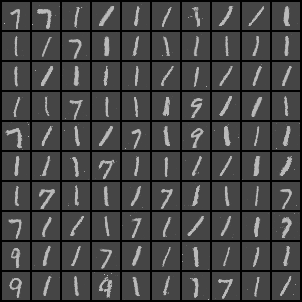

In [22]:
# show output after epochs training
Image.open(os.path.join(sample_dir, "fake_images-0300.png"))

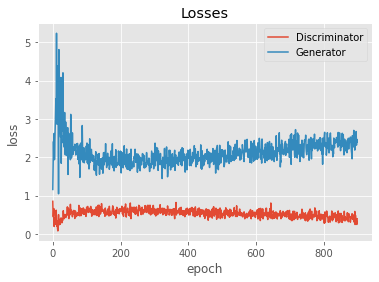

In [23]:
# show the discrimator loss and generator loss
plt.plot(d_losses, "-")
plt.plot(g_losses, "-")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["Discriminator", "Generator"])
plt.title("Losses");

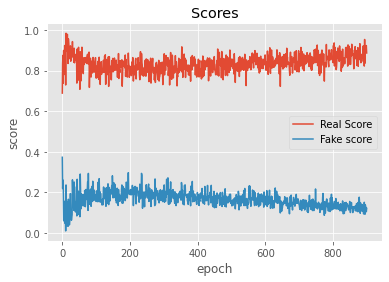

In [24]:
# plot the accuracy of discrimator
plt.plot(real_scores, "-")
plt.plot(fake_scores, "-")
plt.xlabel("epoch")
plt.ylabel("score")
plt.legend(["Real Score", "Fake score"])
plt.title("Scores");

## 2. DCGAN

*Source: <a href="https://arxiv.org/pdf/1511.06434v2.pdf" target="_blank">Radford, Alec, Luke Metz, and Soumith Chintala. "Unsupervised representation learning with deep convolutional generative adversarial networks." arXiv preprint arXiv:1511.06434 (2015)</a>.*

The goal of this part is to enhance your results achieved in the part one with DCGAN. Feel free to reuse your code, improve architecture or training scheme, etc.

In [10]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

from torchvision.datasets import CIFAR10
class CFG:
    batch_size = 128
    num_epochs = 300
    workers = 4
    seed = 2022
    image_size = 64
    download = False
    dataroot = "/home/kontsevaya/dl/dl_hw/"
    nc = 3  ## number of chanels
    ngf = 64  # Size of feature maps in generator
    nz = 100  # latent random input vector
    ndf = 64  # Size of feature maps in discriminator
    lr = 0.0002
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    print(device)
    sample_dir = "./images_cfg_2/"


if not os.path.exists(CFG.sample_dir):
    os.makedirs(CFG.sample_dir)

cifar_dataset = CIFAR10(
    root=CFG.dataroot,
    download=CFG.download,
    transform=transforms.Compose(
        [
            transforms.Resize([CFG.image_size, CFG.image_size]),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    ),
)

cuda:0


Label:  6


(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-0.8745098 , -0.8112418 , -0.74797386, -0.68470585, -0.6214379 ,
        -0.5581699 , -0.49490196, -0.43163398, -0.36836597, -0.305098  ,
        -0.24183004, -0.17856206, -0.11529408, -0.0520261 ,  0.01124188,
         0.07450986], dtype=float32),
 <a list of 300 BarContainer objects>)

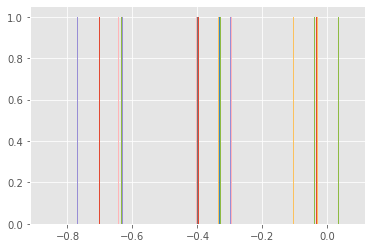

In [11]:
img, label = cifar_dataset[0]
print("Label: ", label)
plt.hist(img[:, 5:15, 5:15].flatten(), bins=15)

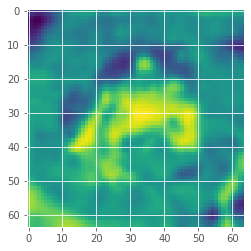

In [12]:
import matplotlib.pyplot as plt

denorm_img = denorm(img)
plt.imshow(torch.permute(denorm_img, (1, 2, 0))[:,:,0])

In [13]:
# create the dataloader
# define the dataloader
data_loader_cfg = torch.utils.data.DataLoader(cifar_dataset,
                                          batch_size=CFG.batch_size,
                                          shuffle=True,
                                            num_workers=4
)

### DCGAN implementation

In [14]:
class DCGenerator(nn.Module):
    def __init__(self, nc, nz, ngf):
        # ConvTranspose2d - BatchNorm - Relu -ConvTranspose2d - BatchNorm - Relu -ConvTranspose2d - BatchNorm - Relu
        # ConvTranspose2d - BatchNorm - Relu - ConvTranspose2d - Tanh
        super(DCGenerator, self).__init__()
        ##
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            # state size. (nc) x 64 x 64
        )

    def forward(self, x):
        x = self.main(x)
        return F.tanh(x)


class DCDiscriminator(nn.Module):
    def __init__(self, nc, ndf):
        # conv2d - leaky - conv2d - batchnorm - leaky - conv2d - batchnorm - leaky - conv - batchnorm - leaky - conv2d
        super(DCDiscriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
        )

    def forward(self, x):
        x = self.main(x)
        return F.sigmoid(x)


In [15]:
# create new Generator model
DCG = DCGenerator(CFG.nc, CFG.nz, CFG.ngf).to(device)

# create new Discriminator model
DCD = DCDiscriminator(CFG.nc, CFG.ndf).to(device)

In [16]:
# show the output of model
y = DCG(torch.randn(CFG.batch_size, CFG.nz, 1, 1).to(device))
y

/home/kontsevaya/sberocrs/sber-ocr-2/.sberocr-env2/lib/python3.6/site-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


tensor([[[[-1.9300e-01, -2.6189e-01, -5.1223e-01,  ..., -2.9970e-01,
           -3.1906e-01, -1.1280e-01],
          [-1.0753e-01,  4.9472e-01, -1.2784e-02,  ...,  3.3989e-01,
            1.3417e-01,  2.1229e-01],
          [-2.5765e-01,  1.8675e-01, -4.1498e-01,  ..., -1.0407e-01,
           -5.1710e-01, -2.4842e-01],
          ...,
          [ 4.7207e-02,  7.5197e-01, -1.0307e-01,  ...,  2.5263e-01,
           -2.8195e-01,  1.0993e-01],
          [-2.3142e-02, -2.6270e-01,  2.9144e-01,  ...,  3.7987e-01,
            2.6446e-01,  3.6618e-02],
          [ 5.6954e-03,  4.4894e-04, -5.9151e-02,  ...,  2.5742e-01,
            2.4749e-02,  1.8902e-01]],

         [[-7.9075e-02, -3.1148e-01, -3.4304e-01,  ...,  4.3765e-02,
           -4.3585e-01,  4.0916e-02],
          [ 1.1284e-01, -2.3671e-01, -1.0915e-01,  ..., -1.8778e-02,
            1.7496e-01, -2.7658e-01],
          [ 1.4500e-01,  3.7361e-01,  1.4291e-01,  ..., -2.1950e-01,
            4.8694e-01, -1.7644e-01],
          ...,
     

In [17]:
# define the criterion is nn.BCELoss()
criterion = nn.BCELoss()
## Define the optimizer for generator and discrimator
beta1 = 0.5
G_optimizer = torch.optim.Adam(DCG.parameters(), lr=CFG.lr, betas=(beta1, 0.999))
D_optimizer = torch.optim.Adam(DCD.parameters(), lr=CFG.lr, betas=(beta1, 0.999))

In [60]:
# feel free to reuse your training functions

### Start the training proccess

In [18]:
def save_fake_images_cifar(DCG_model, index):
    sample_vectors = torch.randn(CFG.batch_size, CFG.nz, 1, 1).to(CFG.device)
    fake_images = DCG_model(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 3, 64, 64)
    fake_fname = "fake_images-{0:0=4d}.png".format(index)
    print("Saving", fake_fname)
    save_image(
        denorm(fake_images), os.path.join(CFG.sample_dir, fake_fname), nrow=10
    )

In [19]:
%%time
device = CFG.device
num_epochs = CFG.num_epochs
batch_size = CFG.batch_size

total_step = len(data_loader_cfg)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []
DCG.to(device)
DCD.to(device)

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader_cfg):
        # Load a batch & transform to vectors
        images = Variable(images.to(device))

        # Train the discriminator
        if (i + 1) % 2 == 0:
            d_loss, real_score, fake_score = train_discriminator(DCD, DCG, images, z_shape=(batch_size, CFG.nz, 1, 1))
        # Train the generator
        g_loss, fake_images = train_generator(DCG, DCD, z_shape=(batch_size, CFG.nz, 1, 1))
        # Inspect the losses
        if (i + 1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print(
                "Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}".format(
                    epoch,
                    num_epochs,
                    i + 1,
                    total_step,
                    d_loss.item(),
                    g_loss.item(),
                    real_score.mean().item(),
                    fake_score.mean().item(),
                )
            )
    # Sample and save images
    save_fake_images_cifar(DCG, epoch + 1)

/home/kontsevaya/sberocrs/sber-ocr-2/.sberocr-env2/lib/python3.6/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch [0/300], Step [200/391], d_loss: 0.9508, g_loss: 2.0234, D(x): 0.53, D(G(z)): 0.23
Saving fake_images-0001.png
Epoch [1/300], Step [200/391], d_loss: 0.9248, g_loss: 1.9431, D(x): 0.63, D(G(z)): 0.33
Saving fake_images-0002.png
Epoch [2/300], Step [200/391], d_loss: 1.3988, g_loss: 2.1603, D(x): 0.67, D(G(z)): 0.60
Saving fake_images-0003.png
Epoch [3/300], Step [200/391], d_loss: 1.0789, g_loss: 1.3074, D(x): 0.49, D(G(z)): 0.28
Saving fake_images-0004.png
Epoch [4/300], Step [200/391], d_loss: 1.2345, g_loss: 2.0088, D(x): 0.74, D(G(z)): 0.59
Saving fake_images-0005.png
Epoch [5/300], Step [200/391], d_loss: 1.1083, g_loss: 1.3249, D(x): 0.51, D(G(z)): 0.32
Saving fake_images-0006.png
Epoch [6/300], Step [200/391], d_loss: 1.0181, g_loss: 1.5792, D(x): 0.42, D(G(z)): 0.10
Saving fake_images-0007.png
Epoch [7/300], Step [200/391], d_loss: 0.7261, g_loss: 1.8763, D(x): 0.67, D(G(z)): 0.26
Saving fake_images-0008.png
Epoch [8/300], Step [200/391], d_loss: 3.3447, g_loss: 4.0668, D

Saving fake_images-0070.png
Epoch [70/300], Step [200/391], d_loss: 0.0111, g_loss: 6.7976, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0071.png
Epoch [71/300], Step [200/391], d_loss: 0.0148, g_loss: 6.7238, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0072.png
Epoch [72/300], Step [200/391], d_loss: 0.0101, g_loss: 7.8961, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0073.png
Epoch [73/300], Step [200/391], d_loss: 0.4964, g_loss: 2.4315, D(x): 0.87, D(G(z)): 0.25
Saving fake_images-0074.png
Epoch [74/300], Step [200/391], d_loss: 0.0074, g_loss: 5.9371, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0075.png
Epoch [75/300], Step [200/391], d_loss: 0.3385, g_loss: 4.1191, D(x): 0.98, D(G(z)): 0.23
Saving fake_images-0076.png
Epoch [76/300], Step [200/391], d_loss: 0.0349, g_loss: 5.7642, D(x): 0.97, D(G(z)): 0.01
Saving fake_images-0077.png
Epoch [77/300], Step [200/391], d_loss: 0.0419, g_loss: 8.3815, D(x): 0.96, D(G(z)): 0.00
Saving fake_images-0078.png
Epoch [78/300], Step [200/39

Epoch [139/300], Step [200/391], d_loss: 0.0612, g_loss: 4.5257, D(x): 0.96, D(G(z)): 0.02
Saving fake_images-0140.png
Epoch [140/300], Step [200/391], d_loss: 0.0571, g_loss: 4.3766, D(x): 0.97, D(G(z)): 0.02
Saving fake_images-0141.png
Epoch [141/300], Step [200/391], d_loss: 0.1406, g_loss: 10.5497, D(x): 1.00, D(G(z)): 0.12
Saving fake_images-0142.png
Epoch [142/300], Step [200/391], d_loss: 0.0913, g_loss: 6.4363, D(x): 0.93, D(G(z)): 0.01
Saving fake_images-0143.png
Epoch [143/300], Step [200/391], d_loss: 0.0320, g_loss: 5.7694, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0144.png
Epoch [144/300], Step [200/391], d_loss: 0.0618, g_loss: 5.9036, D(x): 0.97, D(G(z)): 0.03
Saving fake_images-0145.png
Epoch [145/300], Step [200/391], d_loss: 0.0353, g_loss: 5.6382, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0146.png
Epoch [146/300], Step [200/391], d_loss: 0.2002, g_loss: 7.6075, D(x): 0.99, D(G(z)): 0.16
Saving fake_images-0147.png
Epoch [147/300], Step [200/391], d_loss: 0.0289

Epoch [211/300], Step [200/391], d_loss: 0.0960, g_loss: 7.2321, D(x): 0.99, D(G(z)): 0.08
Saving fake_images-0212.png
Epoch [212/300], Step [200/391], d_loss: 0.1608, g_loss: 8.1755, D(x): 0.88, D(G(z)): 0.00
Saving fake_images-0213.png
Epoch [213/300], Step [200/391], d_loss: 0.0517, g_loss: 5.3079, D(x): 0.99, D(G(z)): 0.04
Saving fake_images-0214.png
Epoch [214/300], Step [200/391], d_loss: 0.3107, g_loss: 8.6260, D(x): 0.97, D(G(z)): 0.22
Saving fake_images-0215.png
Epoch [215/300], Step [200/391], d_loss: 0.0858, g_loss: 5.3103, D(x): 0.99, D(G(z)): 0.06
Saving fake_images-0216.png
Epoch [216/300], Step [200/391], d_loss: 0.0865, g_loss: 5.9772, D(x): 0.99, D(G(z)): 0.06
Saving fake_images-0217.png
Epoch [217/300], Step [200/391], d_loss: 0.3727, g_loss: 13.2188, D(x): 1.00, D(G(z)): 0.27
Saving fake_images-0218.png
Epoch [218/300], Step [200/391], d_loss: 5.3090, g_loss: 7.3014, D(x): 0.05, D(G(z)): 0.00
Saving fake_images-0219.png
Epoch [219/300], Step [200/391], d_loss: 0.1029

Epoch [280/300], Step [200/391], d_loss: 0.0212, g_loss: 7.4064, D(x): 0.99, D(G(z)): 0.01
Saving fake_images-0281.png
Epoch [281/300], Step [200/391], d_loss: 0.0225, g_loss: 6.7573, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0282.png
Epoch [282/300], Step [200/391], d_loss: 0.0787, g_loss: 3.8965, D(x): 0.96, D(G(z)): 0.03
Saving fake_images-0283.png
Epoch [283/300], Step [200/391], d_loss: 0.0294, g_loss: 7.6855, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0284.png
Epoch [284/300], Step [200/391], d_loss: 0.1664, g_loss: 5.5485, D(x): 0.96, D(G(z)): 0.10
Saving fake_images-0285.png
Epoch [285/300], Step [200/391], d_loss: 0.0232, g_loss: 6.7793, D(x): 0.99, D(G(z)): 0.01
Saving fake_images-0286.png
Epoch [286/300], Step [200/391], d_loss: 0.0808, g_loss: 6.6158, D(x): 0.96, D(G(z)): 0.03
Saving fake_images-0287.png
Epoch [287/300], Step [200/391], d_loss: 0.1141, g_loss: 7.7589, D(x): 0.98, D(G(z)): 0.07
Saving fake_images-0288.png
Epoch [288/300], Step [200/391], d_loss: 0.0233,

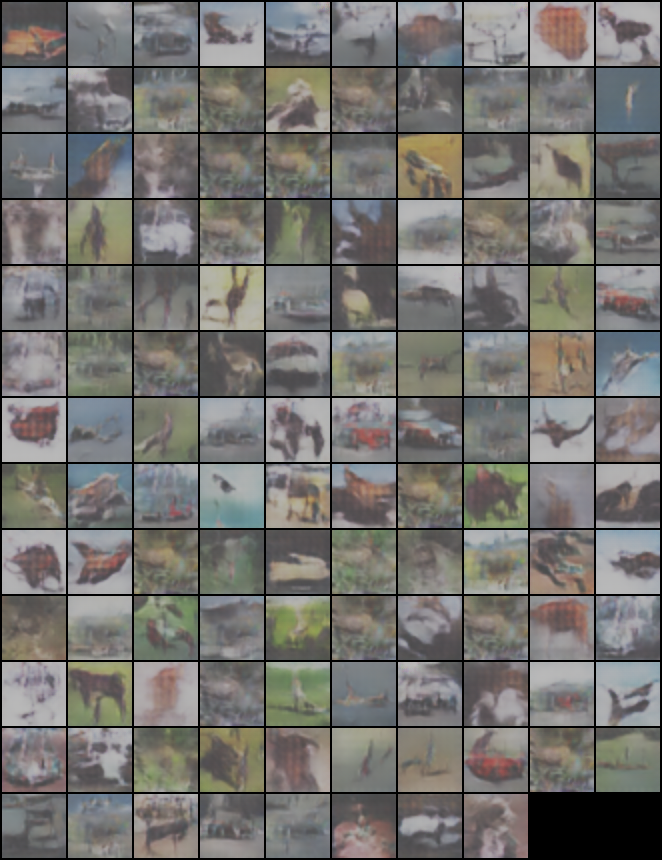

In [26]:
# show your results!
Image.open(os.path.join(CFG.sample_dir, "fake_images-0134.png"))

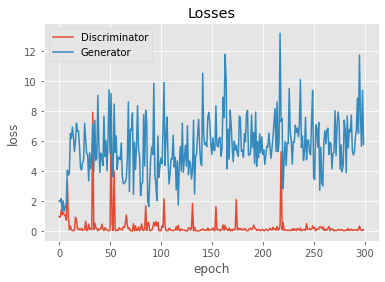

In [21]:
# show the discrimator loss and generator loss
plt.plot(d_losses, "-")
plt.plot(g_losses, "-")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["Discriminator", "Generator"])
plt.title("Losses");

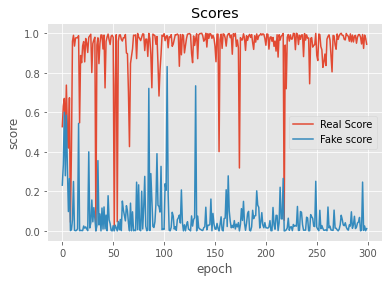

In [22]:
# plot the accuracy of discrimator
plt.plot(real_scores, "-")
plt.plot(fake_scores, "-")
plt.xlabel("epoch")
plt.ylabel("score")
plt.legend(["Real Score", "Fake score"])
plt.title("Scores");